##Метод возможных направлений

Метод возможных направлений представляет собой метод решения следующей задачи оптимизации:

$$f(x) → min, \;\;\; x \in P$$
$$P = \{g_j(x) \leq 0, \;\; j = 1,..,m\}$$

Функции $f, \ g_i, \ i = 1,..,m \;$ (скалярные функции векторного аргумента) предполагаются дифференцируемыми с непрерывными частными производными \[1\].  

За основу реализации взят алгоритм, описанный в \[2\].

---

\[1\] *Zoutendijk G.* Methods of Feasible Directions: A Study in Linear and Non-Linear Programming. — Elsevier Publishing Company. — 1960. — P. 78-79.

\[2\] *Rao S.S.* Engineering Optimization: Theory and Practice. 4th Edition. — John Wiley & Sons, Inc. — 2009. — P. 393-403


In [99]:
# Import the modules used

import sympy as sp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [100]:
# In this program the SymPy symbols, the functions and their gradients
# are in the global scope, for simplicity

# Add symbols at your discretion
# Control the dimensionality of the problem
x, y = sp.symbols('x y')
vars = [x, y]

# Instead of hard-coding the tolerances throughout the program, it was decided
# to make them global variables instead. As long as tol_precision >> tol_solution,
# it should be fine.
step_size = 0.001
max_iter = 5000
tol_alpha = 1e-9  # e1
tol_solution = 1e-9  # e2
tol_change = 1e-9  # e3
tol_precision = 1e-6  # e4

In [101]:
# Calculate and store the gradients (symbolic) (symbolic differentiation via SymPy)
# The functions are assumed to be differentiable (at each point of the feasible region).

# The gradient of the objective function
# I.e. [partial df/dx, ..., partial df/dz]
f_grad = sp.Matrix([sp.diff(f, var) for var in vars])

# The list of the gradients of the constraints
# I.e. [gradient_of_g1, gradient_of_g2, ..., gradient_of_gn]
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

In [102]:
def to_float(obj):
    """
    Converts a SymPy expression or matrix (after numeric substitution)
    to float or list (np.array) of floats (vector/matrix).
    """
    # For gradients (vectors) convert to list of floats
    if isinstance(obj, sp.Matrix):
        return np.array([float(x.evalf()) for x in obj])
    # For SymPy numbers convert to a number (float)
    else:
        return float(obj)


def calculate(function, point):
    """
    A function wrapping the SymPy subs() function
    Calculates the symbolic expression substituting variables for numbers

    Args:
    function: a sympy expression
    point: a list representing the function's arguments

    Returns:
    Either a float, if evaluation yields a number, or an array of floats, if evaluation is performed on a vector-function
    """

    return to_float(function.subs([(vars[i], point[i]) for i in range(len(vars))]))


def find_feasible_direction(x_i):
    """
    Solve a linear programming problem to find a feasible direction if active constraints at x_i are present,
    otherwise return the pair (antigradient of f, 1)

    Args:
    x_i: current point

    Returns:
    A pair (feasible_direction, alpha), where feasible_direction is a vector and alpha is a number (as per the problem)
    """
    # Because we need to pick the active constraints at x_i
    # and machine precision is limited, choose the tolerance constant
    g_j_is_active = [(True if calculate(g, x_i) > -tol_precision else False) for g in gs]

    if not(any(g_j_is_active)):
        return (calculate(-f_grad, x_i), 1)

    # Construct the linear programming problem constraint matrix
    A = []
    for j in range(len(gs)):
        if g_j_is_active[j]:
            A.append(np.append(calculate(g_grads[j], x_i), 1))

    A.append(np.append(calculate(f_grad, x_i), 1))

    # The right hand side is zero, as per the problem
    b = [0] * len(A)

    bounds = [(-1, 1)] * len(vars)  # bounds for s1, s2, ..., sn (The first n variables in the LP problem)
    bounds.append((None, None))  # bounds for alpha (no bounds for the last variable in the LP problem)

    c = [0] * len(vars) + [-1] # The LP objective function (minus alpha)

    res = linprog(
        c=c,
        A_ub=A,
        b_ub=b,
        bounds=bounds,
        method='highs'
    )

    feasible_direction = res['x'][:-1]
    alpha = -res['fun']

    return (np.array(feasible_direction), alpha)


def find_next_point(x_i, step_size, feasible_direction):
    """
    An implementation of the so-called "line search"
    Find the step length given the step_size constant and the feasible direction
    and return the next point ( x_(i+1) )

    Args:
    x_i: list of floats
    step_size: float
    feasible_direction: list of floats

    Returns:
    The next point (array of floats)
    """
    # Search for a feasible step length

    while True:
        new_x_i = x_i + step_size * feasible_direction  # * np.linalg.norm(calculate(f_grad, x_i))
        constraints_violated = False
        for g in gs:
            if calculate(g, new_x_i) > 0:
                constraints_violated = True
                break

        if not(constraints_violated) and \
            (calculate(f, new_x_i) < calculate(f, x_i) - tol_change \
            or np.linalg.norm(new_x_i - x_i) < tol_solution):
            return new_x_i
        else:
            # Cut the step_size in half to try and stay within the feasible region (repeat if necessary)
            step_size *= 1 / 2


def make_a_step(x_i):
    """
    make a step in a feasible direction and return a bool flag specifying
    whether any of the termination criteria were satisfied

    Args:
    x_i: where to make the step from

    Returns:
    A triplet (x_(i+1), function_value_at_x_(i+1), True if optimal else False)
    """

    feasible_direction, alpha = find_feasible_direction(x_i)

    # terminate if one of the termination conditions is reached (alpha < tolerance)
    if alpha < tol_alpha:
        return (x_i, calculate(f, x_i), True)

    new_x_i = find_next_point(x_i, step_size, feasible_direction)

    if np.linalg.norm(new_x_i - x_i) < tol_solution:
        return (x_i, calculate(f, x_i), True)

    return (new_x_i, calculate(f, new_x_i), False)


def find_optimal(initial_guess, record_history=False):
    """
    Apply MFD to try and find the optimal point

    Args:
    initial_guess: list of floats (must satisfy all constraints)
    record_history: bool, default False. If True, returns the iteration history.

    Returns:
    A pair (optimal_point, function_value_at_optimal_point) if record_history=False (default)
    A triplet (optimal_point, function_value_at_optimal_point, history) if record_history=True
    """

    # Check whether the initial guess is in the feasible region
    for g in gs:
        if calculate(g, initial_guess) > 0:
            raise ValueError("Initial guess is not in the feasible region")

    # Main algorithm
    x_i = np.array(initial_guess)
    history = [[x_i.copy(), calculate(f, x_i)]] if record_history else None

    for iter in range(max_iter):
        step_results = make_a_step(x_i)
        if record_history:
            history.append([step_results[0].copy(), step_results[1]])
        # step_result[2] will contain True once it detects one of the termination criterions
        if step_results[2]:
            break
        else:
            x_i = step_results[0]

    if record_history:
        return step_results[0],  step_results[1], history
    else:
        return step_results[0], step_results[1]

## Тестирование

In [104]:
def visualize():
    # Lambda functions for fast evaluation on NumPy arrays
    f_np = sp.lambdify((x, y), f, modules='numpy')
    g_nps = [sp.lambdify((x, y), g, modules='numpy') for g in gs]

    iterate_points = np.array([step[0] for step in history])

    margin = 0.5
    x_min, x_max = iterate_points[:,0].min() - margin, iterate_points[:,0].max() + margin
    y_min, y_max = iterate_points[:,1].min() - margin, iterate_points[:,1].max() + margin

    # Create grid
    x_vals = np.linspace(x_min, x_max, 400)
    y_vals = np.linspace(y_min, y_max, 400)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Evaluate objective function on grid
    Z = f_np(X, Y)

    # Plot heatmap of objective function
    plt.figure(figsize=(12, 10))
    plt.imshow(Z, extent=[x_min, x_max, y_min, y_max],
            origin='lower', cmap='inferno', aspect='auto')
    plt.colorbar(label='Objective function value')

    # Plot feasible region boundaries (g = 0)
    for g_np in g_nps:
        Zg = g_np(X, Y)
        plt.contour(X, Y, Zg, levels=[0], colors='blue', linewidths=2)

    # Plot iterates
    iterate_points = np.array([step[0] for step in history])
    values = np.array([step[1] for step in history])

    plt.plot(iterate_points[:,0], iterate_points[:,1], marker='o', color='white', label='step', linewidth=2)
    plt.scatter(iterate_points[:,0], iterate_points[:,1], c=values, cmap='viridis', edgecolor='k', s=80, label='path')

    for i, (x_val, y_val) in enumerate(iterate_points):
        if i % 5 == 0:
            plt.text(x_val + 0.02, y_val + 0.02, str(i), color='red', fontsize=9, weight='bold')
        elif i == len(iterate_points) - 1:
            plt.text(x_val - 0.1, y_val - 0.1, str(i), color='pink', fontsize=13, weight='bold')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Feasible Directions Method Path (Heatmap)')
    plt.legend()
    plt.show()

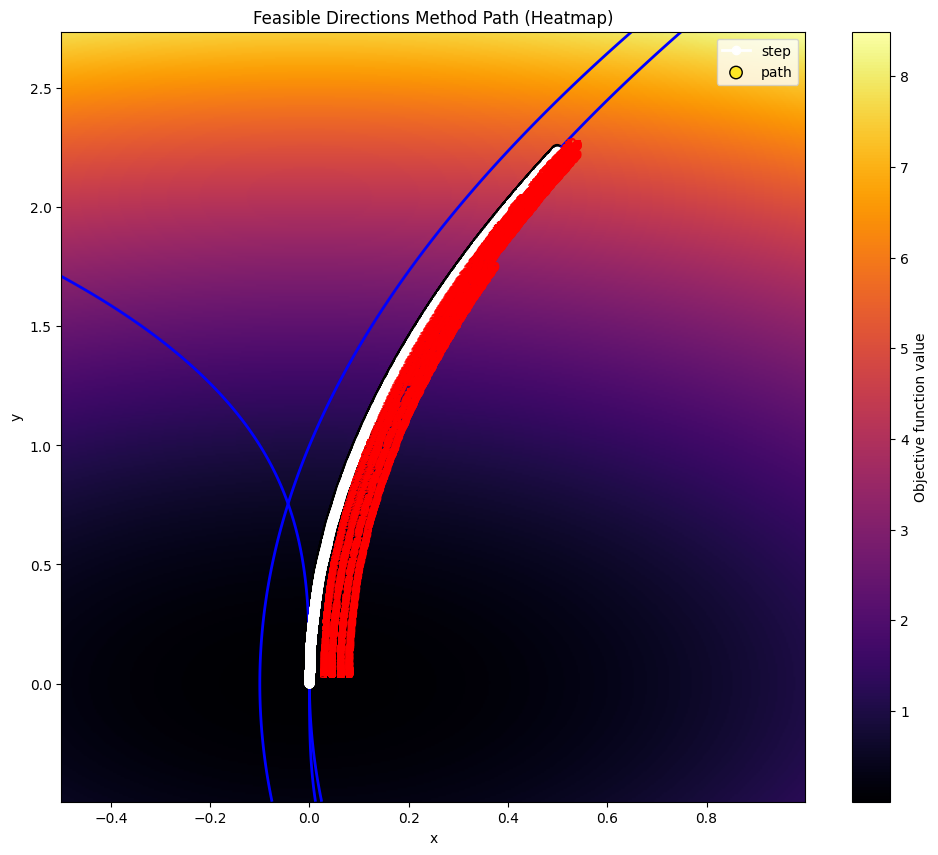

In [105]:
f = (x**2 + y**2)
# Constraints: circular feasible region with a bottleneck
gs = [
    10 * x - y**2,
    -10 * x - y**3,
    -10 * x - 1 + y**2,
]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

initial_point = [0.5 - 0.001, np.sqrt(5) + 0.001]

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [106]:
len(history)

5001

In [107]:
# The testing was performed *manually*:
print(results[0], results[1])

[8.65221994e-07 3.71583757e-03] 1.3807449632076394e-05


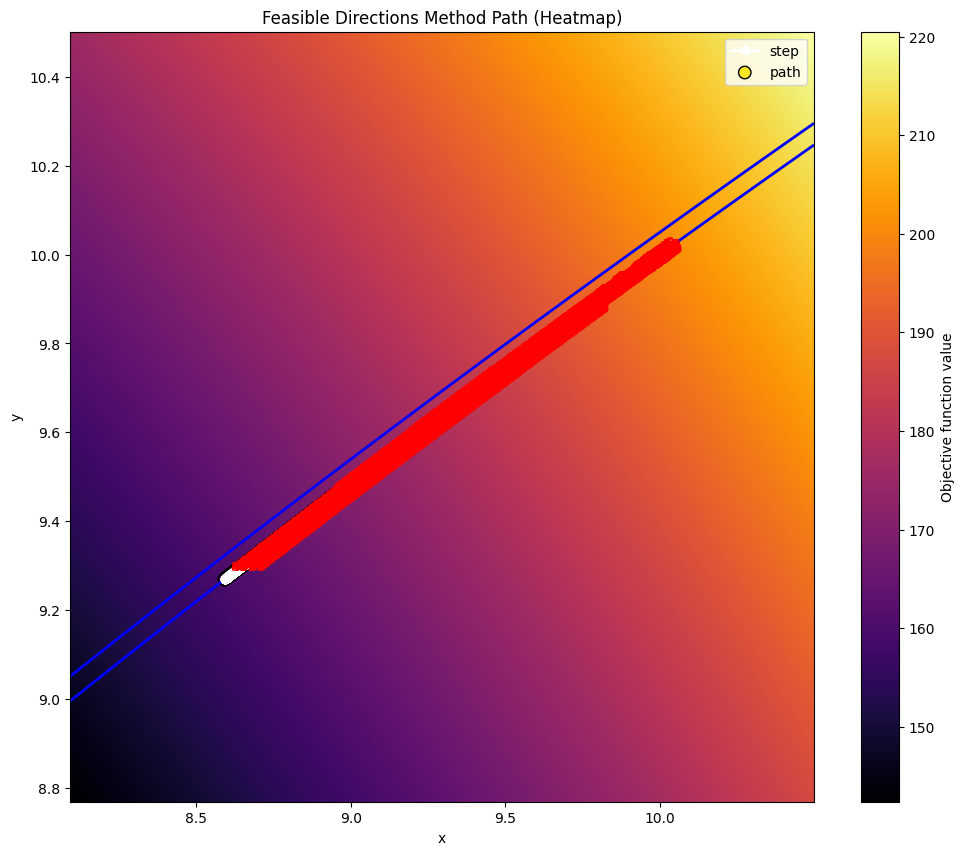

In [108]:
initial_point = [10 - 0.001, np.sqrt(100) + 0.001]

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [109]:
# The testing was performed *manually*:
print(results[0], results[1])

[8.59224616 9.26943743] 159.749164346959


In [110]:
len(history)

5001

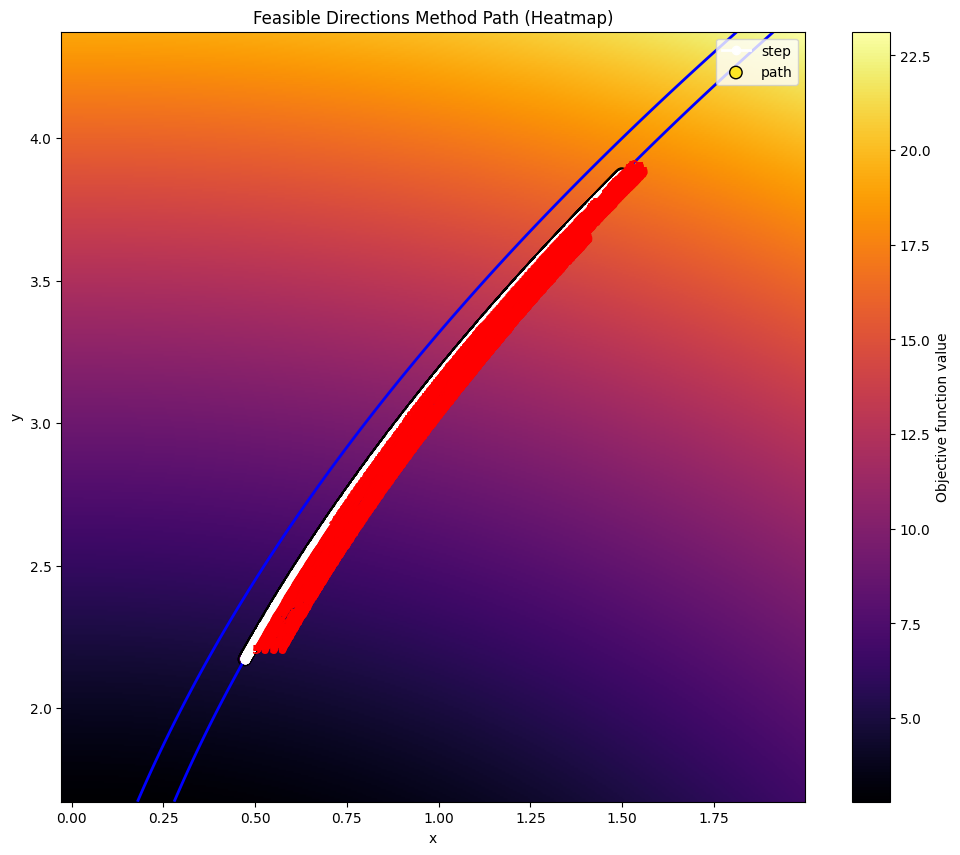

In [111]:
initial_point = [1.5 - 0.001, np.sqrt(15) + 0.001]

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [112]:
len(history)

5001

In [113]:
# The testing was performed *manually*:
print(results[0], results[1])

[0.47136249 2.17108959] 4.93581259309747


In [114]:
# Correct